In [1]:
import pandas as pd
import pysam
import numpy as np
import akita_utils
import h5py

from akita_utils.utils import ut_dense

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from akita_utils.stats_utils import calculate_SCD

In [3]:
def plot_map(matrix, vmin=-0.6, vmax=0.6, width=5, height=5, palette="RdBu_r"):

    """
    Plots a 512x512 map representating changes in the DNA contacts.

    Parameters
    ------------
    matrix : numpy array
        Changes in DNA contacts.
    vmin : float
    vmax : float
        Minimum and maximum in the colormap scale.
    width : int
    height : int
        Width and height of a plotted map.
    """

    fig = plt.figure(figsize=(width, height))

    sns.heatmap(
        matrix,
        vmin=vmin,
        vmax=vmax,
        cbar=False,
        cmap=palette,
        square=True,
        xticklabels=False,
        yticklabels=False,
    )
    plt.show()



In [4]:
def get_bin(
    window_start,
    window_end,
    map_size=512,
    bin_size=2048,
    input_size=1310720,
):

    """
    Returns a list of bins overlapping the given window.

    Parameters
    ------------
    window_start : int
    window_end : int
        Start and end of the window that overlapping bins we want to find.
        Note, those values are in the local coordinates, so between 0 and input_size.
    map_size : int
        Size of the maps (equivalent to number of bins).
    bin_size : int
        The length of each bin in base pairs (bp).
    input_size : int
        Length of model's input sequence.

    Returns
    ---------
    bin_index : int
        The bin overlapping the given window.
    """

    window_size = window_end - window_start

    size_after_cropping = map_size * bin_size
    size_difference = input_size - size_after_cropping
    one_side_cropped_length = size_difference // 2

    corrected_window_start = window_start - one_side_cropped_length
    corrected_window_end = window_end - one_side_cropped_length

    first_bin_covered = corrected_window_start // bin_size
    last_bin_covered = corrected_window_end // bin_size
    
    assert first_bin_covered == last_bin_covered
    
    return first_bin_covered
    

In [5]:
def get_insertion_start_pos(insert_bp, spacer_bp, num_inserts, seq_length = 1310720):

    insert_plus_spacer_bp = insert_bp + 2 * spacer_bp
    multi_insert_bp = num_inserts * insert_plus_spacer_bp
    insert_start_bp = seq_length // 2 - multi_insert_bp // 2

    insertion_starting_positions = []
    for i in range(num_inserts):
        offset = insert_start_bp + i * insert_plus_spacer_bp + spacer_bp
        insertion_starting_positions.append(offset)
        
    return insertion_starting_positions

In [6]:
def get_map_matrix(hf, num_sequences, head_index, model_index, num_background):
    """averaged over targets"""
    
    num_targets = 6
    if head_index != 1:
        num_targets = 5
    
    map_size = np.array(hf[f"e0_h{head_index}_m{model_index}_t0_b0"]).shape[0]
    
    map_matrix = np.zeros((map_size, map_size, num_sequences, num_background))

    for seq_index in range(num_sequences):
        for target_index in range(num_targets):
            for background_index in range(num_background):
                map_matrix[:, :, seq_index, background_index] += np.array(hf[f"e{seq_index}_h{head_index}_m{model_index}_t{target_index}_b{background_index}"])
    
    map_matrix = map_matrix / num_targets
    return map_matrix


In [7]:
def get_reference_matrix(hf, head_index, model_index, num_background):
        
    num_targets = 6
    if head_index != 1:
        num_targets = 5
        
    map_size = np.array(hf[f"ref0_h{head_index}_m{model_index}_t0"]).shape[0]
    
    ref_map_matrix = np.zeros((map_size, map_size, num_background))
    
    for target_index in range(num_targets):
        for background_index in range(num_background):
            ref_map_matrix[:, :, background_index] += np.array(hf[f"ref{background_index}_h{head_index}_m{model_index}_t{target_index}"])
    
    ref_map_matrix = ref_map_matrix / num_targets
    return ref_map_matrix


In [8]:
def subtable_h5_to_df(
    filename,
    columns_of_interest,
    verbose=False,
):
    hf = h5py.File(filename, "r")
    s = []
    for column in columns_of_interest:
        s.append(pd.Series(hf[column][()], name=column))

    hf.close()

    # generating pandas DataFrame and converting bytestrings
    df_out = pd.concat(s, axis=1)
    for key, key_dtype in df_out.dtypes.items():
        if not pd.api.types.is_numeric_dtype(key_dtype):
            df_out[key] = df_out[key].str.decode("utf8").copy()

    return df_out

In [9]:
dots_hf = h5py.File("/home1/smaruj/akita_utils/bin/insert_virtual_dots_vs_boundaries/dots_25motifs/OUT.h5","r")

In [10]:
boundaries_hf = h5py.File("/home1/smaruj/akita_utils/bin/insert_virtual_dots_vs_boundaries/boundaries_25motifs/OUT.h5","r")

In [11]:
# for key in boundaries_hf:
    # print(key, boundaries_hf[key].shape)

In [12]:
columns_to_df = []

for key in boundaries_hf:
    if (key[0] != "e" and key[:3] != "ref"):
        columns_to_df.append(key)

In [13]:
columns_to_df

['background_index',
 'chrom',
 'diffSCD_h1_m0_t0',
 'diffSCD_h1_m0_t1',
 'diffSCD_h1_m0_t2',
 'diffSCD_h1_m0_t3',
 'diffSCD_h1_m0_t4',
 'diffSCD_h1_m0_t5',
 'flank_bp',
 'genomic_SCD',
 'orientation',
 'spacer_bp',
 'start',
 'strand']

In [14]:
df = subtable_h5_to_df(
    "/home1/smaruj/akita_utils/bin/insert_virtual_dots_vs_boundaries/boundaries_25motifs/OUT.h5",
    columns_to_df)

In [15]:
df.columns

Index(['background_index', 'chrom', 'diffSCD_h1_m0_t0', 'diffSCD_h1_m0_t1',
       'diffSCD_h1_m0_t2', 'diffSCD_h1_m0_t3', 'diffSCD_h1_m0_t4',
       'diffSCD_h1_m0_t5', 'flank_bp', 'genomic_SCD', 'orientation',
       'spacer_bp', 'start', 'strand'],
      dtype='object')

In [16]:
starts = get_insertion_start_pos(insert_bp=59, spacer_bp=99980, num_inserts=2)

In [17]:
insert_bp=59
row_line, col_line = get_bin(starts[0], starts[0]+insert_bp), get_bin(starts[1], starts[1]+insert_bp)

In [18]:
row_line, col_line

(207, 304)

In [19]:
halfsize = 15

In [20]:
num_sequences = 25
head_index = 1
model_index = 0
num_backgrounds = 10

In [21]:
boundaries_matrix = get_map_matrix(boundaries_hf, num_sequences, head_index, model_index, num_backgrounds)

In [22]:
boundaries_matrix_ave_bgs = np.average(boundaries_matrix, axis=3)

In [23]:
ref_map_matrix = get_reference_matrix(boundaries_hf, head_index, model_index, num_backgrounds)

In [24]:
scd_scores_all = []

for seq_index in range(25):
    for background_index in range(num_backgrounds):
        scd = calculate_SCD(boundaries_matrix[:, :, seq_index, background_index], reference_map_matrix=ref_map_matrix[:, :, background_index])
        scd_scores_all.append(scd)

In [25]:
df["SCD"] = scd_scores_all

In [26]:
dot_matrix = get_map_matrix(dots_hf, num_sequences, head_index, model_index, num_backgrounds)

In [27]:
def sum_squares(map_fragment):
    
    return np.sqrt((map_fragment**2).sum(axis=(0,1))) * (1/2)

In [28]:
def dot_alone(dot_matrix):
    
    # central, dot part
    dot_score = sum_squares(dot_matrix[10:20, 10:20])
    return dot_score

In [29]:
def dot_score_x(dot_matrix):
    
    # central, dot part
    dot_score = sum_squares(dot_matrix[10:20, 10:20])
    
    # x-parts
    x_score = 0
    for matrix_part in [dot_matrix[:10, :10], dot_matrix[:10, 20:], dot_matrix[20:, :10], dot_matrix[20:, 20:]]:
        x_score += sum_squares(matrix_part)
        
    return x_score / dot_score

In [30]:
def dot_score_cross(dot_matrix):
    
    # central, dot part
    dot_score = sum_squares(dot_matrix[10:20, 10:20])
    
    # cross-parts
    cross_score = 0
    for matrix_part in [dot_matrix[:10, 10:20], dot_matrix[10:20, :10], dot_matrix[10:20, 20:], dot_matrix[20:, 10:20]]:
        cross_score += sum_squares(matrix_part)
        
    return cross_score / dot_score

In [31]:
dot_alone_all = []
dot_x_all = []
dot_cross_all = []

for seq_index in range(25):
    for background_index in range(num_backgrounds):
        scd = calculate_SCD(boundaries_matrix[:, :, seq_index, background_index], reference_map_matrix=ref_map_matrix[:, :, background_index])
        scd_scores_all.append(scd)
        

for seq_index in range(25):
    for background_index in range(num_backgrounds):
        dot = dot_matrix[row_line-halfsize: row_line+halfsize, col_line-halfsize:col_line+halfsize, seq_index, background_index]
        dot_alone_all.append(dot_score_cross(dot))
        dot_x_all.append(dot_score_x(dot))
        dot_cross_all.append(dot_score_cross(dot))
        

In [32]:
df["dot"] = dot_alone_all
df["dot_x"] = dot_x_all
df["dot_cross"] = dot_cross_all

<AxesSubplot:xlabel='SCD', ylabel='dot_cross'>

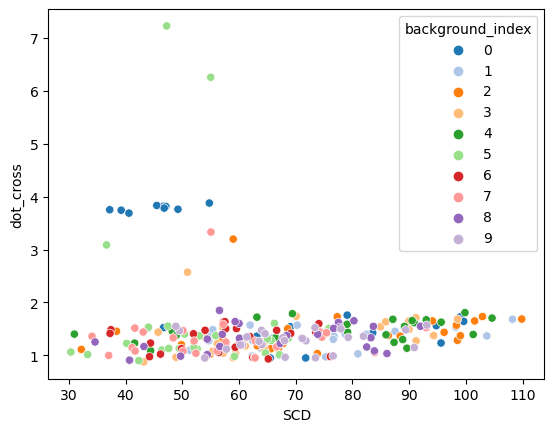

In [33]:
sns.scatterplot(data=df, x="SCD", y="dot_cross", hue="background_index", palette="tab20")

<AxesSubplot:xlabel='SCD', ylabel='dot'>

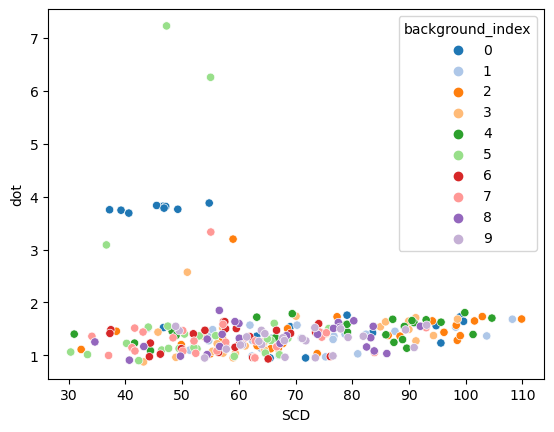

In [34]:
sns.scatterplot(data=df, x="SCD", y="dot", hue="background_index", palette="tab20")

<AxesSubplot:xlabel='SCD', ylabel='dot_x'>

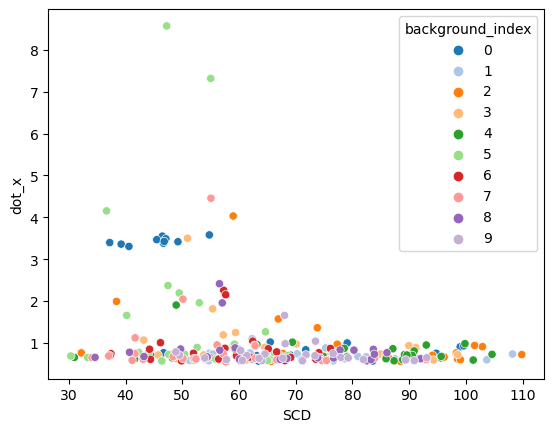

In [35]:
sns.scatterplot(data=df, x="SCD", y="dot_x", hue="background_index", palette="tab20")

In [36]:
df

,background_index,chrom,diffSCD_h1_m0_t0,diffSCD_h1_m0_t1,diffSCD_h1_m0_t2,diffSCD_h1_m0_t3,diffSCD_h1_m0_t4,diffSCD_h1_m0_t5,flank_bp,genomic_SCD,orientation,spacer_bp,start,strand,SCD,dot,dot_x,dot_cross
0,0,chr12,0.0,0.0,0.0,0.0,0.0,0.0,20,53.78,<>,99980,35192361,+,46.491874,3.815678,3.550468,3.815678
1,0,chr2,0.0,0.0,0.0,0.0,0.0,0.0,20,53.70,<>,99980,48886252,-,39.235490,3.743507,3.359366,3.743507
2,0,chr12,0.0,0.0,0.0,0.0,0.0,0.0,20,53.66,<>,99980,35192359,-,46.692337,3.819003,3.381116,3.819003
3,0,chr8,0.0,0.0,0.0,0.0,0.0,0.0,20,53.50,<>,99980,102781112,-,37.217518,3.751744,3.395751,3.751744
4,0,chr5,0.0,0.0,0.0,0.0,0.0,0.0,20,53.30,<>,99980,49961991,-,45.513270,3.832849,3.466252,3.832849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,9,chr12,0.0,0.0,0.0,0.0,0.0,0.0,20,51.06,<>,99980,57825931,+,71.816655,1.273657,0.713192,1.273657
246,9,chr3,0.0,0.0,0.0,0.0,0.0,0.0,20,50.94,<>,99980,57843966,+,57.788335,1.116186,0.600422,1.116186
247,9,chr16,0.0,0.0,0.0,0.0,0.0,0.0,20,50.80,<>,99980,22564764,+,89.402852,1.480375,0.591854,1.480375
248,9,chr7,0.0,0.0,0.0,0.0,0.0,0.0,20,50.60,<>,99980,132213675,-,76.600355,0.987962,0.743458,0.987962
